# Using Soundscapy for Binaural Recording Analysis

In v0.3.2, the ability to perform a huge suite of (psycho)acoustic analyses has been added to Soundscapy. This has been optimised for performing batch processing of many recordings, ease of use, and reproducibility. To do this, we rely on three packages to provide the analysis functions:

 * [Python Acoustics](https://github.com/python-acoustics/python-acoustics) (`acoustics`) : Python Acoustics is a library aimed at acousticians. It provides two huge benefits - first, all of the analysis functions are referenced directly to the relevant standard. Second, we subclass their `Signal` class to provide the Binaural functionality and any function available within the `Signal` class is also available to Soundscapy's `Binaural` class.
 * [scikit-maad](https://scikit-maad.github.io) (`maad`) : scikit-maad is a modular toolbox for quantitiative soundscape analysis, focussed on ecological soundscapes and bioacoustic indices. scikit-maad provides a huge suite of ecosoundscape focussed indices, including Acoustic Richness Index, Acoustic Complexity Index, Normalized Difference Soundscape Index (NDSI), and more.
 * [MoSQITo](https://github.com/Eomys/MoSQITo) (`mosqito`): MoSQITo is a modular framework of key sound quality metrics, providing the psychoacoustic metrics.

The metrics currently available are:
* Python Acoustics : $L_{Zeq}$, $L_{Aeq}$, $L_{Ceq}$, SEL, and all associated statistics ($L_5$ through $L_{95}$, $L_{max}$ and $L_{min}$, as well as [kurtosis](https://acousticstoday.org/wp-content/uploads/2020/12/Kurtosis-A-New-Tool-for-Noise-Analysis-Wei-Qiu-William-J.-Murphy-and-Alice-Suter.pdf) and skewness.
* scikit-maad : So far we have only implemented the combined `all_temporal_alpha_indices` and `all_spectral_alpha_indices` from `scikit-maad`; calculating them individually is not yet supported. `all_temporal_alpha_indices` comprises 16 temporal domain acoustic indices, such as temporal signal-to-noise-ratio, temporal entropy, temporal events. `all_spectral_alpha_indices` comprises 19 spectral domain acoustic indices, such as Bioacoustic Index, Acoustic Diversity Index, NDSI, Acoustic Evenness Index.
* MoSQITo :
    * Loudness (Zwicker time varying),
    * Sharpness (time varying, from loudness, and per segment with DIN, Aures, Bismarck, and Fastl weightings),
    * Roughness (Daniel and Weber, 1997).

Soundscapy combines all of these metrics and makes it easy and (relatively) fast to compute any or all of them for a binaural audio recording. These results have been preliminarily confirmed through comparison of results obtained from Head Acoustics ArtemiS suite on a set of real-world recordings.

## Consistent Analysis Settings

A primary goal when developing this library was to make it easy to save and document the settings used for all analyses. This is done through a `settings.yaml` file and the `AnalysisSettings` class. Although the settings for each metric can be set at runtime, the `settings.yaml` file allows you to set all of the settings at once and document exactly what settings were passed to each analysis function and to share these settings with collaborators or reviewers.

## Batch processing
The other primary goal was to make it simple and fast to perform this analysis on many recordings. One aspect of this is unifying the outputs from the underlying libraries and presenting them in an easy to parse format. The analysis functions from Soundscapy can return a MultiIndex pandas DataFrame with the Recording filename and Left and Right channels in the index and a column for each metric calculated. This dataframe can then be easily saved to a .csv or Excel spreadsheet. Alternatively, a dictionary can be returned for further processing within Python. The key point is that after calculating 100+ metrics for 1,000+ recordings, you'll be left with a single tidy spreadsheet.

The Soundscape Indices (SSID) project for which this was developed has over 3,000 recordings for which we needed to calculate a full suite of metrics for both channels. In particular, the MoSQITo functions can be quite slow, so running each recording one at a time can be prohibitively slow and only utilize a small portion of the available computing power. To help with this, a set of simple functions is provided to enable parallel processing, such that multiple recordings can be processed simultaneously by a multi-core CPU. In our initial tests on a 16-core AMD Ryzen 7 4800HS CPU (Fedora Linux 36), this increased the speed for processing 20 recordings by at least 8 times.

In testing, the MoSQITo functions are particularly slow, taking up to 3 minutes to calculate the Loudness for a 30s two-channel recording. When running only a single recording through, this has also been sped up by parallelizing the per-channel calculation, reducing the computation time to around 50s.

# Getting Started

The basis of all of our analysis starts with the binaural signal, so we begin by importing the `Binaural` class. We'll also load up and examine our analysis settings. Throughout Soundscapy, we use `pathlib.Path` for defining filepaths.


In [1]:
# Add soundscapy to the Python path
import sys
sys.path.append('..')

# imports
from soundscapy import Binaural
from soundscapy import AnalysisSettings
from soundscapy.analysis.binaural import prep_multiindex_df, add_results, process_all_metrics
import json
from pathlib import Path


Set up where the data is located. In this case, we'll use the sample recordings located under the `test` folder.

In [2]:
# May need to adjust for your system
wav_folder = Path().cwd().parent.joinpath("test", "data")


Ensuring that Soundscapy knows exactly how loud your recordings were onsite is crucial to getting correct answers. If you used equipment such as the Head Acoustics SqoBold, and were careful about how the recordings are exported to .wav, then they may already be correctly adjusted (as ours are here). However its best to be safe and calibrate each signal to their real-world dB level. To do this, we load in a .json that contains the per-channel correct dB $L_{eq}$ level.

In [3]:
levels = wav_folder.joinpath("Levels.json")

with open(levels) as f:
    levels = json.load(f)

# Look at the first five sets of levels
list(levels.items())[:5]

[('CT101', {'Left': 79.0, 'Right': 79.72}),
 ('CT102', {'Left': 79.35, 'Right': 79.88}),
 ('CT103', {'Left': 76.25, 'Right': 76.41}),
 ('CT104', {'Left': 79.9, 'Right': 79.93}),
 ('CT107', {'Left': 78.21, 'Right': 78.47})]


### Prepping the results dataframe
The easiest way to organise and add the new data as it is processed is to prepare a dataframe ahead of time. We've provided a small function to convert a dictionary of calibration levels (`level`) into the properly formatted dataframe.

In [4]:
df = prep_multiindex_df(levels, incl_metric=True)
df.head()

Leq
Recording Channel       
CT101     Left     79.00
          Right    79.72
CT102     Left     79.35
          Right    79.88
CT103     Left     76.25

#### Load in a Binaural recording
Load in a binaural wav signal. We can use the `plot` function provided by the `acoustics.Signal` super-class.

<AxesSubplot:title={'center':'Signal'}, xlabel='$t$ in s', ylabel='$x$ in -'>

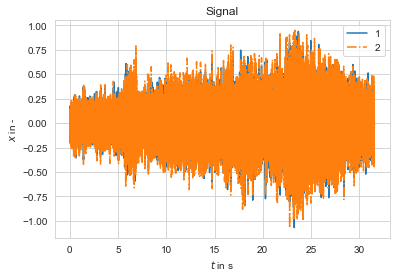

In [5]:
binaural_wav = wav_folder.joinpath("CT101.wav")
b = Binaural.from_wav(binaural_wav)
b.plot()

To ensure that the dB level is correct, and therefore any other metrics are correct, we start by calibrating the signal to precalculated levels.


In [6]:
decibel = (levels[b.recording]["Left"], levels[b.recording]["Right"])
print(f"Calibration levels: {decibel}")
b.calibrate_to(decibel, inplace=True)

Calibration levels: (79.0, 79.72)


Signal([[-0.01080703 -0.0088621  -0.01002671 ... -0.0432281  -0.04708166
  -0.04911411]
 [-0.00745821  0.00049144  0.00590268 ... -0.00493154 -0.01020068
  -0.01875182]])

Now, check it by comparing it to what we already knew were the correct levels:

In [7]:
print(f"Predefined levels: {levels[b.recording]}")
print(f"Calculated Levels: {b.pyacoustics_metric('Leq', statistics=['avg'], as_df=False)}")

Predefined levels: {'Left': 79.0, 'Right': 79.72}
Calculated Levels: {'Left': {'Leq': 79.00281378626991}, 'Right': {'Leq': 79.72243397536936}}


## Calculating Acoustic Metrics

This brings us to how to calculate any of the many metrics available. Let's start simple with $L_{Aeq}$.

#### Python Acoustics

Since the $L_{Aeq}$ calc is provided by the Python Acoustics library, we'll be calling `pyacoustic_metric`. Then, we need to tell it what particular metric we want, what stats to calculate as well, what to label it, and what format to return the results in.

In [8]:
metric = "LAeq"
stats = ("avg", 10, 50, 90, 95, "max")
label = "LAeq"
b.pyacoustics_metric(metric, stats, label, as_df=False)

{'Left': {'LAeq': 68.87570321376752,
  'LAeq_10': 71.15434218749783,
  'LAeq_50': 68.11333930746,
  'LAeq_90': 63.375090914754985,
  'LAeq_95': 62.366533277575606,
  'LAeq_max': 77.38265089009883},
 'Right': {'LAeq': 69.95333344074137,
  'LAeq_10': 72.57815150741932,
  'LAeq_50': 68.49539857979003,
  'LAeq_90': 64.53305677178045,
  'LAeq_95': 63.09765925624846,
  'LAeq_max': 78.70878341389864}}

If we want, we can get the results back as a pandas DataFrame instead:

In [9]:
b.pyacoustics_metric(metric, stats, label, as_df=True)

LAeq    LAeq_10    LAeq_50    LAeq_90    LAeq_95  \
Recording Channel                                                          
CT101     Left     68.875703  71.154342  68.113339  63.375091  62.366533   
          Right    69.953333  72.578152  68.495399  64.533057  63.097659   

                    LAeq_max  
Recording Channel             
CT101     Left     77.382651  
          Right    78.708783

And we can easily do the same for the C-weighting level:

In [10]:
b.pyacoustics_metric("LCeq", stats, as_df=True)

LCeq    LCeq_10    LCeq_50    LCeq_90    LCeq_95  \
Recording Channel                                                          
CT101     Left     77.245094  80.008421  76.256223  71.467371  70.627245   
          Right    77.855473  80.633065  76.882287  72.463130  71.262000   

                    LCeq_max  
Recording Channel             
CT101     Left     84.307204  
          Right    84.806283

#### MoSQITo

MoSQITo is very exciting as it is one of the first completely free and open-source libraries for calculating psychoacoustic features. Let's try out calculating the psychoacoustic loudness.

We start by defining many of the same options, but with two new ones. The first is our `func_args` to pass to `MoSQITo`. Since our test recording was collected in a public park, we need to select the correct field type: free or diffuse, and pass that to MoSQITo.

The second new argument is `parallel`. This just tells Soundscapy whether to try to calculate the Left and Right channels simultaneously to speed up processing.

In [11]:
metric = "loudness_zwtv"
stats = (5, 50, 'avg', 'max')
func_args = {
    'field_type': 'free'
}

b.mosqito_metric(metric, statistics=stats, as_df=True, parallel=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metric: loudness_zwtv


N_5       N_50      N_avg      N_max
Recording Channel                                            
CT101     Left     28.834482  23.164299  22.669519  36.160815
          Right    30.834215  23.939352  23.774119  37.762344

`sharpness_din_from_loudness` is a bit of a special case to keep in mind. It can drastically speed up the processing time since it calculates the Sharpness values from pre-calculated Loudness results. If you are planning to do both analyses, I highly suggest using it. Soundscapy will handle it behind the scenes to make sure it doesn't accidentally calculate the Loudness values twice if you've asked for both of them. Let's try it out.

In [12]:
b.mosqito_metric("sharpness_din_from_loudness", stats, as_df=True, parallel=True, verbose=True, func_args=func_args)

 - Calculating MoSQITo metrics: `sharpness_din` from `loudness_zwtv`


N_5       N_50      N_avg      N_max       S_5  \
Recording Channel                                                         
CT101     Left     28.834482  23.164299  22.669519  36.160815  1.339030   
          Right    30.834215  23.939352  23.774119  37.762344  1.410216   

                       S_50     S_avg      S_max  
Recording Channel                                 
CT101     Left     1.168987  1.181871  19.298406  
          Right    1.183683  1.202704  18.598348

By default, the metrics will be calculated for both channels. But you may want only a single channel. This can be set with the `channel` option.

In [13]:
b.pyacoustics_metric("LZeq", channel="Left")

,LZeq,LZeq_5,LZeq_10,LZeq_50,LZeq_90,LZeq_95,LZeq_max,LZeq_min,LZeq_kurt,LZeq_skew
CT101,79.002814,83.065062,81.694714,77.969857,73.533225,72.283847,86.270916,70.194097,-0.088419,-0.056522


In [14]:
b.maad_metric("all_spectral_alpha_indices", verbose=True)

 - Calculating scikit-maad all_spectral_alpha_indices


MEANf      VARf     SKEWf       KURTf  NBPEAKS  \
Recording Channel                                                      
CT101     Left     0.001616  0.000050  9.903323  122.639052       48   
          Right    0.001767  0.000057  9.775576  121.145848       25   

                        LEQf       ENRf       BGNf      SNRf       Hf  ...  \
Recording Channel                                                      ...   
CT101     Left     77.288435 -15.711565 -19.025828  3.314263  0.33898  ...   
          Right    77.862094 -15.137906 -18.647919  3.510013  0.34690  ...   

                       TFSD  H_Havrda   H_Renyi  H_pairedShannon      H_gamma  \
Recording Channel                                                               
CT101     Left     0.196529  0.306220  1.254553         2.981413  1004.342457   
          Right    0.202233  0.306565  1.260965         3.032816  1054.904505   

                   H_GiniSimpson      RAOQ       AGI  ROItotal  ROIcover  
Recording Channel                                                         
CT101     Left          0.767638  0.012133  1.502837        38  3.335626  
          Right         0.771196  0.014212  1.505844        23  1.761245  

[2 rows x 44 columns]

### Defining Analysis Settings

Soundscapy provides the ability to predefine your analysis settings. These are defined in a separate `.yaml` file and are managed by Soundscapy using the `AnalysisSettings` class. These settings can then be passed to any of the analysis functions, rather than separately defining your settings as we did above. This will be particularly useful when performing our batch processing on an entire folder of wav recordings later.

Soundscapy provides a set of default settings which can be easily loaded in:

In [15]:
analysis_settings = AnalysisSettings.default()

However, in your own analysis you'll probably want to define your own options and load that in. We'll show how this is done using the `example_settings.yaml' file. First, let's take a look at how it's laid out:

```
# Settings file for batch acoustic analysis.
# Split up according to which library performs which analysis.

# Python Acoustics
# Supported metrics: LAeq, LZeq, LCeq, SEL
# Supported stats: avg/mean, max, min, kurt, skew, any integer from 1-99
PythonAcoustics:
    LAeq:
        run: true
        main: 'avg'
        statistics: [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew']
        channel: ["Left", "Right"]
        label: 'LAeq'
        func_args:
            time: 0.125
            method: "average"

    LZeq:
        run: true
        main: 'avg'
        statistics: [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew']
        channel: ["Left", "Right"]
        label: 'LZeq'
        func_args:
            time: 0.125
            method: "average"

# MoSQITo
# supported metrics: loudness_zwtv, sharpness_din_from_loudness, roughness_dw
# supported stats: avg/mean, max, min, kurt, skew, any integer from 1-99
MoSQITo:
    loudness_zwtv:
        run: true
        main: 5
        statistics: [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg']
        channel: ["Left", "Right"]
        label: "N"
        parallel: true
        func_args:
            field_type: "free"

```


The settings file is broken up according to the three libraries. Within these, we define separate options for each metric to calculate. The name of this metric should correspond exactly with what Soundscapy expects (in the case of PythonAcoustics) or what the underlying library calls its function.

Within each function, we then have a collection of settings that Soundscapy uses:
    * `run` : This tells Soundscapy whether or not to actually run this metric. This allows you to define and save the options you use for each metric without needing to run it.
    * `main` and `statistics` : These are the sub-statistics to calculate (e.g. $L_{5}$, $L_{90}$, etc.). `main` operates just like any of these, except you also have the option to return only the main statistic to simplify your results while still leaving your other preferences intact.
    * `label` : What label to assign that metric. For instance, Loudness is typically `'N'`. When calculated, the statistics will be appended like so: N_5, N_10, N_avg, ... N_{`stat`} and this will be the column name for that metric. If you pass nothing here, then Soundscapy will fall back to the labels defined in `sq_metrics.DEFAULT_LABELS`. **Warning**: Some functions share a label (e.g. `sharpness_din_tv` and `sharpness_din_perseg` are both 'S'), if you run both of these and don't define different labels, one will overwrite the other.

Finally, there is an opportunity to define arguments to pass to the underlying function itself. This is perhaps the most important part for consistency and reproducibility. This is where you define which standard is being used, what time or frequency weighting, or what spectrogram bins to use. These options are defined by the 3 analysis libraries used and are not documented fully in Soundscapy. When the `AnalysisSettings` is parsed, `func_args` will be returned as a `dict` with an entry for each option you'd like to pass. `func_args` is then passed as `**kwargs` to e.g. the `mosqito.sq_metrics.loudness_zwtv()` function. If `func_args` contains an option the function doesn't recognise it will throw an error, so be careful when defining these arguments.

---------------------------------------
Let's try loading in the `example_settings.yaml` file and see how `AnalysisSettings` handles it.

In [16]:
ex_settings = AnalysisSettings.from_yaml(Path("example_settings.yaml"))
ex_settings

{'PythonAcoustics': {'LAeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LAeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LZeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LZeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'LCeq': {'run': True,
   'main': 'avg',
   'statistics': [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew'],
   'channel': ['Left', 'Right'],
   'label': 'LCeq',
   'func_args': {'time': 0.125, 'method': 'average'}},
  'SEL': {'run': True,
   'main': [],
   'statistics': [],
   'channel': ['Left', 'Right'],
   'label': 'SEL'}},
 'MoSQITo': {'loudness_zwtv': {'run': False,
   'main': 5,
   'statistics': [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
   'channel': ['Left', 'Right'],
   'label': 'N',
   'parallel': True,
   'func_arg

`ex_settings` is just a Python `dict` with some class methods added on. One of these is a function to parse the settings object for a specific library:


In [17]:
ex_settings.parse_pyacoustics(metric="LAeq")

(True,
 ['Left', 'Right'],
 [5, 10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
 'LAeq',
 {'time': 0.125, 'method': 'average'})

This returns the value for `run`, `channel`, `statistics`, `label`, and `func_args` which will then be used by the `pyacoustic_metric()` function to calculate the $L_{Aeq}$ and its stats.

When passing your settings to an analysis function, it will start by automatically parsing and applying the settings for that particular metric. This will override any other settings passed to the function, so if you're using a settings file and you want to change anything, you should either change it in the `.yaml` and reload the settings. This also makes sure you keep a record of the settings for the last time you ran the analysis.

You can easily reload the settings `.yaml` after changing it:

In [18]:
ex_settings = ex_settings.reload()

### Running a single metric with predefined settings

Now, with our settings loaded, we process a recording using those settings:

In [19]:
b.pyacoustics_metric("LAeq", analysis_settings=ex_settings)

LAeq     LAeq_5    LAeq_10    LAeq_50    LAeq_90  \
Recording Channel                                                          
CT101     Left     68.875703  72.257301  71.154342  68.113339  63.375091   
          Right    69.953333  73.623236  72.578152  68.495399  64.533057   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  
Recording Channel                                                         
CT101     Left     62.366533  60.560166  77.382651   0.272011  -0.013877  
          Right    63.097659  60.520566  78.708783   0.473515   0.140450

But this is just the start of what makes the analysis settings so useful.

## Processing all the metrics at once, using predefined analysis settings.

Since we can define the settings for all the metrics, and specify which metrics we want to run, we can process all of our desired metrics at once. `process_all_metrics()` let's us do this with just a single line of code.

In [20]:
b.process_all_metrics(ex_settings, verbose=True)

Processing CT101
 - Calculating Python Acoustics metrics: LAeq
 - Calculating Python Acoustics metrics: LZeq
 - Calculating Python Acoustics metrics: LCeq
 - Calculating Python Acoustics metrics: SEL
 - Calculating scikit-maad all_temporal_alpha_indices


LAeq     LAeq_5    LAeq_10    LAeq_50    LAeq_90  \
Recording Channel                                                          
CT101     Left     68.875703  72.257301  71.154342  68.113339  63.375091   
          Right    69.953333  73.623236  72.578152  68.495399  64.533057   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  ...  \
Recording Channel                                                         ...   
CT101     Left     62.366533  60.560166  77.382651   0.272011  -0.013877  ...   
          Right    63.097659  60.520566  78.708783   0.473515   0.140450  ...   

                        BGNt      SNRt       MED        Ht  ACTtFraction  \
Recording Channel                                                          
CT101     Left    -10.055829  1.367418  0.314202  0.960724      0.209797   
          Right    -9.282139  1.339588  0.343473  0.961327      0.206419   

                   ACTtCount  ACTtMean  EVNtFraction  EVNtMean  EVNtCount  
Recording Channel                                                          
CT101     Left           621  5.108619      0.158108  0.044177   3.580179  
          Right          611  5.074564      0.153041  0.041655   3.675228  

[2 rows x 47 columns]

In this case we left out the MoSQITo metrics since they take a while, but let's say you do want to run those. You could either edit the `example_settings.yaml` file and use `ex_settings.reload()`, or what we'll do within this notebook is just directly edit the underlying dict.

In [21]:
ex_settings['MoSQITo']["loudness_zwtv"]["run"] = True

b.process_all_metrics(ex_settings, verbose=True)

Processing CT101
 - Calculating Python Acoustics metrics: LAeq
 - Calculating Python Acoustics metrics: LZeq
 - Calculating Python Acoustics metrics: LCeq
 - Calculating Python Acoustics metrics: SEL
 - Calculating MoSQITo metric: loudness_zwtv
 - Calculating scikit-maad all_temporal_alpha_indices


LAeq     LAeq_5    LAeq_10    LAeq_50    LAeq_90  \
Recording Channel                                                          
CT101     Left     68.875703  72.257301  71.154342  68.113339  63.375091   
          Right    69.953333  73.623236  72.578152  68.495399  64.533057   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  ...  \
Recording Channel                                                         ...   
CT101     Left     62.366533  60.560166  77.382651   0.272011  -0.013877  ...   
          Right    63.097659  60.520566  78.708783   0.473515   0.140450  ...   

                        BGNt      SNRt       MED        Ht  ACTtFraction  \
Recording Channel                                                          
CT101     Left    -10.055829  1.367418  0.314202  0.960724      0.209797   
          Right    -9.282139  1.339588  0.343473  0.961327      0.206419   

                   ACTtCount  ACTtMean  EVNtFraction  EVNtMean  EVNtCount  
Recording Channel                                                          
CT101     Left           621  5.108619      0.158108  0.044177   3.580179  
          Right          611  5.074564      0.153041  0.041655   3.675228  

[2 rows x 57 columns]

And now we have all of the same metrics from before, along with the psychoacoustic Loudness.

## Batch processing a bunch of recordings.

The final step is to run all of these metrics on a whole bunch of wav recordings all at once. In the Soundscape Indices (SSID) project for which this package was developed, we use this data to train machine learning models, so it's necessary to process a large number of recordings. Using the predefined analysis settings, we can loop through an entire folder, add it all to the results dataframe and come away with a single spreadsheet of all of the metrics needed.

To start, we'll demonstrate this using a normal `for` loop. The `for` loop will process one recording at a time and add it to our results dataframe. For the demonstration, we'll reload all of the variables needed and use the default analysis settings to run all of the metrics and time it.

In [22]:
import time # Just for timing

wav_folder = Path().cwd().parent.joinpath("test", "data")
levels = wav_folder.joinpath("Levels.json")
with open(levels) as f:
    levels = json.load(f)
df = prep_multiindex_df(levels, incl_metric=False)

analysis_settings = AnalysisSettings.default()

begin = time.perf_counter() # Start timer

# Loop through each wav file in the folder
for wav in wav_folder.glob("*.wav"):
    recording = wav.stem
    decibel = tuple(levels[recording].values())
    b = Binaural.from_wav(wav, calibrate_to=decibel)
    df = add_results(df, b.process_all_metrics(analysis_settings, verbose=True)) # Process all metrics and add to results df

end = time.perf_counter() # Stop timer

Processing CT101
 - Calculating Python Acoustics metrics: LAeq
 - Calculating Python Acoustics metrics: LZeq
 - Calculating Python Acoustics metrics: LCeq
 - Calculating Python Acoustics metrics: SEL
 - Calculating MoSQITo metrics: `sharpness_din` from `loudness_zwtv`
 - Calculating MoSQITo metric: sharpness_din_perseg
 - Calculating MoSQITo metric: roughness_dw
 - Calculating scikit-maad all_temporal_alpha_indices
 - Calculating scikit-maad all_spectral_alpha_indices
Processing CT102
 - Calculating Python Acoustics metrics: LAeq
 - Calculating Python Acoustics metrics: LZeq
 - Calculating Python Acoustics metrics: LCeq
 - Calculating Python Acoustics metrics: SEL
 - Calculating MoSQITo metrics: `sharpness_din` from `loudness_zwtv`
 - Calculating MoSQITo metric: sharpness_din_perseg
 - Calculating MoSQITo metric: roughness_dw
 - Calculating scikit-maad all_temporal_alpha_indices
 - Calculating scikit-maad all_spectral_alpha_indices
Processing CT103
 - Calculating Python Acoustics metri

In [23]:
print("Run on 16 core AMD Ryzen 7 4800HS (Windows 11)")
print(f"Time taken (using for loop): {end-begin: .2f} seconds ({(end-begin)/60: .2f} minutes)")
df

Run on 16 core AMD Ryzen 7 4800HS (Windows 11)
Time taken (using for loop):  2437.06 seconds ( 40.62 minutes)


LAeq     LAeq_5    LAeq_10    LAeq_50    LAeq_90  \
Recording Channel                                                          
CT101     Left     68.875703  72.257301  71.154342  68.113339  63.375091   
          Right    69.953333  73.623236  72.578152  68.495399  64.533057   
CT102     Left     70.613447  74.541317  73.322597  69.297264  65.074481   
          Right    70.491840  75.681356  73.055797  69.131814  64.975452   
CT103     Left     66.330006  69.010487  68.241612  65.579475  63.680847   
...                      ...        ...        ...        ...        ...   
SM518     Right          NaN        NaN        NaN        NaN        NaN   
SM519     Left           NaN        NaN        NaN        NaN        NaN   
          Right          NaN        NaN        NaN        NaN        NaN   
SM520     Left           NaN        NaN        NaN        NaN        NaN   
          Right          NaN        NaN        NaN        NaN        NaN   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  ...  \
Recording Channel                                                         ...   
CT101     Left     62.366533  60.560166  77.382651   0.272011  -0.013877  ...   
          Right    63.097659  60.520566  78.708783   0.473515   0.140450  ...   
CT102     Left     64.561974  63.337182  78.922344   0.270694   0.530142  ...   
          Right    64.209771  63.114758  81.634943   0.648596   0.601576  ...   
CT103     Left     63.194765  62.103353  74.234566   2.236365   1.127518  ...   
...                      ...        ...        ...        ...        ...  ...   
SM518     Right          NaN        NaN        NaN        NaN        NaN  ...   
SM519     Left           NaN        NaN        NaN        NaN        NaN  ...   
          Right          NaN        NaN        NaN        NaN        NaN  ...   
SM520     Left           NaN        NaN        NaN        NaN        NaN  ...   
          Right          NaN        NaN        NaN        NaN        NaN  ...   

                       TFSD  H_Havrda   H_Renyi  H_pairedShannon      H_gamma  \
Recording Channel                                                               
CT101     Left     0.196529  0.306220  1.254553         2.981413  1004.342457   
          Right    0.202233  0.306565  1.260965         3.032816  1054.904505   
CT102     Left     0.228492  0.315584  1.466408         3.338958  1570.553167   
          Right    0.203362  0.314666  1.441181         3.266859  1171.085166   
CT103     Left     0.205715  0.309768  1.324691         3.109321  1062.343059   
...                     ...       ...       ...              ...          ...   
SM518     Right         NaN       NaN       NaN              NaN          NaN   
SM519     Left          NaN       NaN       NaN              NaN          NaN   
          Right         NaN       NaN       NaN              NaN          NaN   
SM520     Left          NaN       NaN       NaN              NaN          NaN   
          Right         NaN       NaN       NaN              NaN          NaN   

                   H_GiniSimpson      RAOQ       AGI  ROItotal  ROIcover  
Recording Channel                                                         
CT101     Left          0.767638  0.012133  1.502837      38.0  3.335626  
          Right         0.771196  0.014212  1.505844      23.0  1.761245  
CT102     Left          0.817882  0.018555  1.649930       2.0  3.491107  
          Right         0.813338  0.012127  1.497617      50.0  2.735081  
CT103     Left          0.785795  0.013687  1.484989     117.0  4.195455  
...                          ...       ...       ...       ...       ...  
SM518     Right              NaN       NaN       NaN       NaN       NaN  
SM519     Left               NaN       NaN       NaN       NaN       NaN  
          Right              NaN       NaN       NaN       NaN       NaN  
SM520     Left               NaN       NaN       NaN       NaN       NaN  
          Right            

As we can see, this took quite a long time. The problem is that the MoSQITo metrics can take up to a minute for each channel of each recording and the for loop only processes one recording at a time. Since most modern computers are multicore, this leaves a ton of processing power unused. On my machine, I have 16 cores and at any one time during this process, only two of those cores are running at 100%.

In order to take full advantage of the other cores, we need to tell the computer to process multiple recordings at once and add them all together later. This is called parallel processing and could theoretically speed up the analysis by 8x (usually we don't get this full speed up though). The reason two cores are running in parallel above is because we're already running both channels at the same time for the MoSQITo metrics.

To do this, we provide a function called `parallel_process()` which takes the path to your wav folder as an argument, then performs our full processing on multiple recordings in parallel and returns the full result dataframe at the end.

Note: Don't worry about the status updates looking  a bit jumbled - that's what happens with parallel processing.

In [24]:
import time
from soundscapy.analysis.parallel_processing import parallel_process

# Redefine path etc. just for the example
wav_folder = Path().cwd().parent.joinpath("test", "data")
levels = wav_folder.joinpath("Levels.json")
with open(levels) as f:
    levels = json.load(f)
df = prep_multiindex_df(levels, incl_metric=False)
analysis_settings = AnalysisSettings.default()

start = time.perf_counter() # Start timer

df = parallel_process(
    wav_folder.glob("*.wav"), df, levels, analysis_settings, verbose=False
)

stop = time.perf_counter()

In [27]:
print("Run on 16 core AMD Ryzen 7 4800HS (Windows 11)")
print(f"Time taken: {stop-start:.2f} seconds ({(stop-start)/60: .2f} minutes)")
df

Run on 16 core AMD Ryzen 7 4800HS (Windows 11)
Time taken: 839.38 seconds ( 13.99 minutes)


LAeq     LAeq_5    LAeq_10    LAeq_50    LAeq_90  \
Recording Channel                                                          
CT101     Left     68.875703  72.257301  71.154342  68.113339  63.375091   
          Right    69.953333  73.623236  72.578152  68.495399  64.533057   
CT102     Left     70.613447  74.541317  73.322597  69.297264  65.074481   
          Right    70.491840  75.681356  73.055797  69.131814  64.975452   
CT103     Left     66.330006  69.010487  68.241612  65.579475  63.680847   
...                      ...        ...        ...        ...        ...   
SM518     Right          NaN        NaN        NaN        NaN        NaN   
SM519     Left           NaN        NaN        NaN        NaN        NaN   
          Right          NaN        NaN        NaN        NaN        NaN   
SM520     Left           NaN        NaN        NaN        NaN        NaN   
          Right          NaN        NaN        NaN        NaN        NaN   

                     LAeq_95   LAeq_min   LAeq_max  LAeq_kurt  LAeq_skew  ...  \
Recording Channel                                                         ...   
CT101     Left     62.366533  60.560166  77.382651   0.272011  -0.013877  ...   
          Right    63.097659  60.520566  78.708783   0.473515   0.140450  ...   
CT102     Left     64.561974  63.337182  78.922344   0.270694   0.530142  ...   
          Right    64.209771  63.114758  81.634943   0.648596   0.601576  ...   
CT103     Left     63.194765  62.103353  74.234566   2.236365   1.127518  ...   
...                      ...        ...        ...        ...        ...  ...   
SM518     Right          NaN        NaN        NaN        NaN        NaN  ...   
SM519     Left           NaN        NaN        NaN        NaN        NaN  ...   
          Right          NaN        NaN        NaN        NaN        NaN  ...   
SM520     Left           NaN        NaN        NaN        NaN        NaN  ...   
          Right          NaN        NaN        NaN        NaN        NaN  ...   

                       TFSD  H_Havrda   H_Renyi  H_pairedShannon      H_gamma  \
Recording Channel                                                               
CT101     Left     0.196529  0.306220  1.254553         2.981413  1004.342457   
          Right    0.202233  0.306565  1.260965         3.032816  1054.904505   
CT102     Left     0.228492  0.315584  1.466408         3.338958  1570.553167   
          Right    0.203362  0.314666  1.441181         3.266859  1171.085166   
CT103     Left     0.205715  0.309768  1.324691         3.109321  1062.343059   
...                     ...       ...       ...              ...          ...   
SM518     Right         NaN       NaN       NaN              NaN          NaN   
SM519     Left          NaN       NaN       NaN              NaN          NaN   
          Right         NaN       NaN       NaN              NaN          NaN   
SM520     Left          NaN       NaN       NaN              NaN          NaN   
          Right         NaN       NaN       NaN              NaN          NaN   

                   H_GiniSimpson      RAOQ       AGI  ROItotal  ROIcover  
Recording Channel                                                         
CT101     Left          0.767638  0.012133  1.502837      38.0  3.335626  
          Right         0.771196  0.014212  1.505844      23.0  1.761245  
CT102     Left          0.817882  0.018555  1.649930       2.0  3.491107  
          Right         0.813338  0.012127  1.497617      50.0  2.735081  
CT103     Left          0.785795  0.013687  1.484989     117.0  4.195455  
...                          ...       ...       ...       ...       ...  
SM518     Right              NaN       NaN       NaN       NaN       NaN  
SM519     Left               NaN       NaN       NaN       NaN       NaN  
          Right              NaN       NaN       NaN       NaN       NaN  
SM520     Left               NaN       NaN       NaN       NaN       NaN  
          Right            

That's three times as fast! It should be noted that it appears any of the parallel operations, including the parallel channel processing, run faster (~25%) on Linux than on Windows on the same machine.

Then save it if you want to.

In [26]:
# from datetime import datetime
# df.to_excel(wav_folder.joinpath("test", f"ParallelTest_{datetime.today().strftime('%Y-%m-%d')}.xlsx"))